# Bio-JEPA AC 

Based on [V-JEPA 2 AC](https://arxiv.org/abs/2506.09985)

**Goal**
Our goal is to build a World Model for cell biology. In it's current configuration, our model calculates that hitting a cell with a specific gene knockout, or drug if we had it in the dataset, causes specific biological pathways to activate or shut down. Unlike an LLM, this is a predictive simulation that operates entirely within a compressed mathematical space to understand cause and effect.

The process begins with the inputs, which feed the model three distinct pieces of information for every training step. 
	First, it receives the **Before** state, which is data representing a healthy control cell. Instead of a messy list of 20,000 raw gene counts, the tokenizer has already compressed this into a structured set of pathway scores (using [Reactome Pathway 2024 data](https://maayanlab.cloud/Harmonizome/dataset/Reactome+Pathways+2024)). This essentially tells the model that the cell currently has high energy, low stress, and normal growth. 
	Second, the model receives the **Action**, which is the specific perturbation performed in the lab, in our case a CRISPR knockdown of a specific gene. This could also be a drug application or protein introduction if we had the data. This is converted into a learnable "Action Embedding," effectively serving as the command that tells the simulation what event just occurred. 
	Third, the model is given the **After** state, which is the actual knockdown cell observed in the experiment. This third input serves purely as the target or "ground truth"; the model is not allowed to see it while making its prediction, but uses it afterwards in the loss calculation and backprop.

Inside the model, a three-step simulation plays out to process these inputs. It starts with the **Student Encoder**, or the *Perception* module, which looks at the healthy **Before** cell input  and compresses it into a Latent State. At this stage, the model is simply understanding the baseline biological status of the cell. This latent representation is then passed to the **Action-Conditioned Predictor**, which acts as the *Physics Engine.* This component combines the cell's current state with the Action vector. Using a mechanism called Adaptive Layer Normalization (AdaLN), the action actually modulates the internal weights of the neural network, effectively shifting the physical rules of the simulation to match the drug's effects. The **Predictor** then tries to predict, or hellucinate, what the future state of the cell will be, calculating a new vector that represents the cell's condition after the knockout, or drug impact. 

To validate the predictor, simultaneously the **Teacher Encoder** looks at the real **After** data from the lab and encodes it into that same latent space to serve as the judge. To learn, the model compares the predictor output against the Teacher's reality. With backprop, we attempt to minimize the difference between the prediction and the actual outcome, trying to minimize this error over millions of examples. 

In theory, by forcing its predictions to match reality, the model moves beyond simply memorizing data and begins to learn the underlying causal rules of biology. It figures out gene regulatory logic—understanding that if Gene A is knocked down, Pathway B must functionally fail. It learns how different pathways, like inflammation and cell death, are causally linked. Ultimately, we hope it learns the "physics" of how perturbations work, allowing us to eventually simulate the effects of gene mutations, drugs or genetic interventions on cells without having to perform the physical experiment in a wet lab.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import copy
import math
import numpy as np
import glob
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
import random

In [2]:
torch.manual_seed(1337)
random.seed(1337)

## Utils

### ROTARY POSITIONAL EMBEDDINGS (RoPE)
V-JEPA 2 uses 3D-RoPE. We adapt this to 1D-RoPE for our list of Pathway Tokens.

In [3]:
class RotaryEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len=2048):
        super().__init__()
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        t = torch.arange(max_seq_len).type_as(inv_freq)
        freqs = torch.einsum('i,j->ij', t, inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer('emb', emb)

    def forward(self, x):
        # x: [Batch, Seq, Dim]
        # returns cos, sin for the sequence length of x
        n = x.shape[1]
        return self.emb[:n, :].cos(), self.emb[:n, :].sin()

def apply_rotary_pos_emb(x, cos, sin):
    # Standard RoPE rotation
    # split x into half
    d = x.shape[-1] // 2
    x1, x2 = x[..., :d], x[..., d:]
    rotated = torch.cat((-x2, x1), dim=-1)
    return (x * cos) + (rotated * sin)

## Components

### COMPONENT 1: THE ENCODER (STUDENT/TEACHER)

In [4]:
class BioEncoderBlock(nn.Module):
    def __init__(self, dim, heads, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(dim * mlp_ratio), dim)
        )

    def forward(self, x, cos, sin):
        # 1. Attention with RoPE
        x_norm = self.norm1(x)
        
        # Apply RoPE to queries and keys inside attention? 
        # For simplicity in standard PyTorch MHA, we apply it to x before attention
        # (Technically RoPE is applied to Q and K inside, but this approximation works 
        # if we treat x as the carrier of position).
        # STRICT IMPLEMENTATION: manually project Q,K,V, apply RoPE to Q,K, then Attn.
        # We will use the simplified "Inject Position" approach for readability here.
        x_rope = apply_rotary_pos_emb(x_norm, cos, sin)
        
        attn_out, _ = self.attn(x_rope, x_rope, x_norm) # V is not rotated usually
        x = x + attn_out
        
        # 2. MLP
        x = x + self.mlp(self.norm2(x))
        return x

In [5]:
class PathwayEncoder(nn.Module):
    def __init__(self, num_pathways=1024, embed_dim=384, depth=12, heads=2):
        super().__init__()
        # Input: [Batch, Pathways] (Float) -> Project to [Batch, Pathways, Dim]
        self.input_proj = nn.Linear(1, embed_dim)
        
        self.rope = RotaryEmbedding(embed_dim // heads * heads) # Ensure divisibility
        
        self.blocks = nn.ModuleList([
            BioEncoderBlock(embed_dim, heads) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # x: [Batch, Num_Pathways]
        x = x.unsqueeze(-1) # [B, N, 1]
        x = self.input_proj(x) # [B, N, Dim]
        
        # Generate RoPE cache
        cos, sin = self.rope(x)
        cos, sin = cos.to(x.device), sin.to(x.device)
        
        for block in self.blocks:
            x = block(x, cos, sin)
            
        return self.norm(x)

### COMPONENT 2: ACTION-CONDITIONED PREDICTOR (AdaLN)

In [6]:
class AdaLN(nn.Module):
    """
    V-JEPA 2 / DiT Style Conditioning.
    The action vector regresses the Scale (gamma) and Shift (beta) of the normalization.
    """
    def __init__(self, embed_dim, action_dim):
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim, elementwise_affine=False)
        self.action_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(action_dim, 2 * embed_dim)
        )
        # Initialize to identity (gamma=0, beta=0 originally, effectively gamma=1 after logic)
        # Standard practice: zero-init the last layer so action starts as "no-op"
        nn.init.zeros_(self.action_mlp[1].weight)
        nn.init.zeros_(self.action_mlp[1].bias)

    def forward(self, x, action_emb):
        # action_emb: [Batch, Action_Dim]
        style = self.action_mlp(action_emb).unsqueeze(1) # [B, 1, 2*D]
        gamma, beta = style.chunk(2, dim=-1)
        return self.norm(x) * (1 + gamma) + beta

In [7]:
class PredictorBlock(nn.Module):
    def __init__(self, dim, heads, action_dim):
        super().__init__()
        self.attn = nn.MultiheadAttention(dim, heads, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(dim, 4 * dim),
            nn.GELU(),
            nn.Linear(4 * dim, dim)
        )
        self.ada_ln1 = AdaLN(dim, action_dim)
        self.ada_ln2 = AdaLN(dim, action_dim)

    def forward(self, x, action_emb, cos, sin):
        # AdaLN -> Attn (with RoPE) -> Residual
        x_norm = self.ada_ln1(x, action_emb)
        
        # Apply RoPE to Q, K
        x_rope = apply_rotary_pos_emb(x_norm, cos, sin)
        
        attn_out, _ = self.attn(x_rope, x_rope, x_norm) 
        x = x + attn_out
        
        # AdaLN -> MLP -> Residual
        x_norm = self.ada_ln2(x, action_emb)
        x = x + self.mlp(x_norm)
        return x

In [8]:
class ACPredictor(nn.Module):
    def __init__(self, embed_dim=384, action_dim=256, depth=6, heads=2, num_pathways=1024):
        super().__init__()
        self.num_pathways = num_pathways
        
        # Action Embedding (Discrete ID -> Vector)
        # We assume action_ids are passed in
        self.action_embed = nn.Embedding(3000, action_dim) # 3000 max perturbations
        
        # Learnable Queries (The "Mask Tokens" for the future state)
        # We learn one query vector per pathway position
        self.mask_queries = nn.Parameter(torch.randn(1, num_pathways, embed_dim) * 0.02)
        
        self.rope = RotaryEmbedding(embed_dim)
        
        self.blocks = nn.ModuleList([
            PredictorBlock(embed_dim, heads, action_dim) for _ in range(depth)
        ])
        
        self.final_norm = AdaLN(embed_dim, action_dim)

    def forward(self, context_latents, action_ids):
        """
        context_latents: [Batch, N, Dim] (From Student Encoder)
        action_ids: [Batch] (Ints)
        """
        B, N, D = context_latents.shape
        
        # 1. Embed Action
        action_emb = self.action_embed(action_ids) # [B, Action_Dim]
        
        # 2. Construct Input: Context + Mask Queries
        # In V-JEPA, the predictor takes the context AND the queries for what to predict.
        # Since we are predicting the *entire* next state (Treated), we concatenate:
        # [Context_State (RoPE pos 0..N), Mask_Queries (RoPE pos N..2N)]
        # However, for biological simplicity, we can just treat this as a transformation:
        # We want to transform Context -> Predicted Target.
        
        # STRICT V-JEPA APPROACH:
        # The predictor runs on the Queries, attending to the Context.
        # It does NOT process the context deeply again.
        
        queries = self.mask_queries.repeat(B, 1, 1) # [B, N, D]
        
        # We concat for attention purposes (Cross-attention is cleaner, but V-JEPA uses single stream)
        # Input Sequence: [Context, Queries]
        sequence = torch.cat([context_latents, queries], dim=1)
        
        # RoPE: Need to handle the extended sequence length (2N)
        cos, sin = self.rope(sequence)
        cos, sin = cos.to(sequence.device), sin.to(sequence.device)
        
        # 3. Pass through AdaLN Blocks
        for block in self.blocks:
            sequence = block(sequence, action_emb, cos, sin)
            
        sequence = self.final_norm(sequence, action_emb)
        
        # 4. Return only the predicted part (The Queries)
        # We discard the processed context
        predictions = sequence[:, N:, :] 
        return predictions

## Bio-JEPA AC

In [9]:
class BioVJepa2(nn.Module):
    def __init__(self, num_pathways=1024, embed_dim=384):
        super().__init__()
        
        self.student = PathwayEncoder(num_pathways, embed_dim)
        self.teacher = copy.deepcopy(self.student)
        
        # Freeze teacher
        for p in self.teacher.parameters():
            p.requires_grad = False
            
        self.predictor = ACPredictor(embed_dim=embed_dim, action_dim=256, num_pathways=num_pathways)
        
    def forward(self, x_control, x_treated, action_id):
        # 1. Teacher encodes the Target (Treated)
        with torch.no_grad():
            target_latents = self.teacher(x_treated)
            
        # 2. Student encodes the Context (Control)
        # (Optional: Add masking here if you want extra difficulty, 
        # but the task Control->Treated is already hard enough)
        context_latents = self.student(x_control)
        
        # 3. Predictor tries to guess Target given Context + Action
        predicted_latents = self.predictor(context_latents, action_id)
        
        # 4. Latent Loss (L1)
        loss = F.l1_loss(predicted_latents, target_latents)
        
        return loss

    @torch.no_grad()
    def update_teacher(self, m=0.996):
        for param_s, param_t in zip(self.student.parameters(), self.teacher.parameters()):
            param_t.data.mul_(m).add_((1 - m) * param_s.data)

## Training

#### Prep

In [10]:
data_dir = Path('/Users/djemec/data/jepa')
shard_dir = data_dir / 'tokenized'
metadata_path = data_dir / 'perturbation_map.json'
checkpoint_dir = data_dir / 'checkpoint'

In [11]:
BATCH_SIZE = 32
# Steps/epoch = 29 (files) *10000 (chunk size) /8 (batch size) 
epoch_steps = 900
n_embd = 8
n_pathways = 1024
LR = 1e-3
EPOCHS = 2
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
QUANTIZATION_MAX = 20.0 # Must match tokenizer
tok_file_chunk_size = 10000

In [12]:
class PairedShardDataset(Dataset):
    def __init__(self, shard_dir):
        self.files = sorted(shard_dir.glob('*.npz'))
        print(f'Found {len(self.files)} shards.')
        
    def __len__(self):
        # Approx length for progress bar (10k per shard)
        return len(self.files) * tok_file_chunk_size

    def __getitem__(self, idx):
        # Stochastic loading: Pick random shard, then random row
        # This avoids loading 100MB files for just one item in strict order
        file_path = self.files[np.random.randint(len(self.files))]
        
        # Load shard (fast if on SSD)
        try:
            with np.load(file_path) as data:
                # Keys: 'control', 'treated', 'action_ids'
                n_rows = data['action_ids'].shape[0]
                row_idx = np.random.randint(n_rows)
                
                c_raw = data['control'][row_idx]
                t_raw = data['treated'][row_idx]
                act_id = data['action_ids'][row_idx]
        except Exception as e:
            # Fallback for corrupt shard
            print(f"Error loading {file_path}: {e}")
            return self.__getitem__(0)

        # Dequantize
        scale = QUANTIZATION_MAX / (2**32 - 1)
        x_control = torch.tensor(c_raw.astype(np.float32) * scale)
        x_treated = torch.tensor(t_raw.astype(np.float32) * scale)
        action_id = torch.tensor(act_id, dtype=torch.long)
        
        return x_control, x_treated, action_id

#### Training

In [13]:
model = BioVJepa2(num_pathways=n_pathways, embed_dim=n_embd).to(DEVICE)

#### Optimizer

In [87]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)

#### Scheduler

In [88]:

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LR, steps_per_epoch=epoch_steps, epochs=EPOCHS, pct_start=0.05
)

#### Data Loader

In [16]:
dataset = PairedShardDataset(shard_dir)

Found 30 shards.


In [17]:
loader = DataLoader(dataset, batch_size=BATCH_SIZE)

#### Training Loop

In [18]:
lossi = []
step = 0

In [89]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    
    # We manually limit steps per epoch to avoid iterating infinite stochastic loader
    # or just iterate a fixed number of batches
    for i, (xc, xt, aid) in enumerate(loader):
        xc, xt, aid = xc.to(DEVICE), xt.to(DEVICE), aid.to(DEVICE)
        
        optimizer.zero_grad()
        
        loss = model(xc, xt, aid)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        # Update Teacher (V-JEPA Momentum)
        model.update_teacher(m=0.996)

        if scheduler.last_epoch < scheduler.total_steps:
            scheduler.step()

        lossi.append(loss.item())
        total_loss += loss.item()
        step += 1
        
        if i % 10 == 0:
            print(f"Epoch {epoch} | Step {i} | Loss: {loss.item():.5f} | LR: {scheduler.get_last_lr()[0]:.2e}")
        
        if i >= epoch_steps: # End epoch after 2000 batches
            break
            
    avg_loss = total_loss / epoch_steps
    
    print(f"=== Epoch {epoch} Done. Avg Loss: {avg_loss:.5f} ===")
    
    # Save Checkpoint
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch
    }, checkpoint_dir / f'bio_jepa_ckpt_{epoch}.pt')

Epoch 0 | Step 0 | Loss: 0.03244 | LR: 4.03e-05
Epoch 0 | Step 10 | Loss: 0.03172 | LR: 7.57e-05
Epoch 0 | Step 20 | Loss: 0.02705 | LR: 1.66e-04
Epoch 0 | Step 30 | Loss: 0.02096 | LR: 3.00e-04
Epoch 0 | Step 40 | Loss: 0.02006 | LR: 4.61e-04
Epoch 0 | Step 50 | Loss: 0.02163 | LR: 6.29e-04
Epoch 0 | Step 60 | Loss: 0.02477 | LR: 7.84e-04
Epoch 0 | Step 70 | Loss: 0.02900 | LR: 9.06e-04
Epoch 0 | Step 80 | Loss: 0.03065 | LR: 9.81e-04
Epoch 0 | Step 90 | Loss: 0.03458 | LR: 1.00e-03
Epoch 0 | Step 100 | Loss: 0.03511 | LR: 1.00e-03
Epoch 0 | Step 110 | Loss: 0.02865 | LR: 1.00e-03
Epoch 0 | Step 120 | Loss: 0.03264 | LR: 9.99e-04
Epoch 0 | Step 130 | Loss: 0.02944 | LR: 9.99e-04
Epoch 0 | Step 140 | Loss: 0.02590 | LR: 9.98e-04
Epoch 0 | Step 150 | Loss: 0.03171 | LR: 9.97e-04
Epoch 0 | Step 160 | Loss: 0.03044 | LR: 9.96e-04
Epoch 0 | Step 170 | Loss: 0.03206 | LR: 9.94e-04
Epoch 0 | Step 180 | Loss: 0.02859 | LR: 9.93e-04
Epoch 0 | Step 190 | Loss: 0.02837 | LR: 9.91e-04
Epoch 0 | S

KeyboardInterrupt: 

#### Training Loss Plot

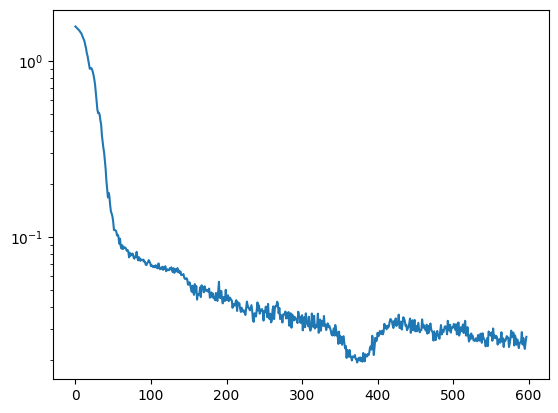

In [90]:
plt.plot(lossi)
plt.yscale('log')

## Test Inference

In [91]:
metadata_path, shard_dir

(PosixPath('/Users/djemec/data/jepa/perturbation_map.json'),
 PosixPath('/Users/djemec/data/jepa/tokenized'))

In [92]:
# 1. Load Map (ID -> Name)
with open(metadata_path, "r") as f:
    pert_map = json.load(f)
# Invert map to: ID -> Name
id_to_name = {v: k for k, v in pert_map.items()}

In [93]:
model.eval()

BioVJepa2(
  (student): PathwayEncoder(
    (input_proj): Linear(in_features=1, out_features=8, bias=True)
    (rope): RotaryEmbedding()
    (blocks): ModuleList(
      (0-11): 12 x BioEncoderBlock(
        (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
        )
        (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=8, out_features=32, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=32, out_features=8, bias=True)
        )
      )
    )
    (norm): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
  )
  (teacher): PathwayEncoder(
    (input_proj): Linear(in_features=1, out_features=8, bias=True)
    (rope): RotaryEmbedding()
    (blocks): ModuleList(
      (0-11): 12 x BioEncoderBlock(
        (norm1): LayerNorm((8,), eps=1e-05, 

**Get random data sample**

In [94]:
def get_random_test_pair(shard_dir):
    '''Grab a single real pair from a random shard'''
    files = sorted(shard_dir.glob('*.npz'))
    file_path = files[np.random.randint(len(files))]
    
    with np.load(file_path) as data:
        idx = np.random.randint(data['action_ids'].shape[0])
        
        # Extract raw uint32
        c_raw = data['control'][idx]
        t_raw = data['treated'][idx]
        act_id = data['action_ids'][idx]
        
    # Dequantize
    scale = QUANTIZATION_MAX / (2**32 - 1)
    x_control = torch.tensor(c_raw.astype(np.float32) * scale).unsqueeze(0).to(DEVICE) # [1, 1024]
    x_treated = torch.tensor(t_raw.astype(np.float32) * scale).unsqueeze(0).to(DEVICE)
    action_id = torch.tensor([act_id], dtype=torch.long).to(DEVICE)
    
    return x_control, x_treated, action_id

In [157]:
x_control, x_real_treated, action_id = get_random_test_pair(shard_dir)
pert_name = id_to_name[action_id.item()]
pert_name

'ARGLU1'

In [158]:
# 2. Get Baselines (Teacher View)
# We need the Teacher to tell us where the "Control" and "Real Treated" 
# sit in the abstract latent space.
with torch.no_grad():
    z_control = model.teacher(x_control)       # Where the cell started
    z_real = model.teacher(x_real_treated)     # Where the cell actually went

In [159]:
# 3. Run The Physics Engine (Predictor)
# Student encodes context -> Predictor adds Action -> Output
with torch.no_grad():
    z_context = model.student(x_control)
    z_predicted = model.predictor(z_context, action_id) # Where the model thinks it went

**Analysis**

In [160]:
# Metric 1: Baseline Drift (How much did the drug actually change the cell?)
# If this is 0, the drug did nothing, so prediction is trivial.
drift = F.l1_loss(z_control, z_real).item()
drift

0.013011535629630089

In [161]:
# Metric 2: Prediction Error (How close is our guess to the real result?)
error = F.l1_loss(z_predicted, z_real).item()
error

0.012903341092169285

In [162]:
# Metric 3: Simulation Magnitude (How much did our model decide to move the cell?)
sim_move = F.l1_loss(z_predicted, z_control).item()
sim_move

0.017940839752554893

In [163]:
# --- INTERPRETATION ---
print(f"[Result Interpretation]")
if drift < 0.01:
    print(f"⚠️  WEAK SIGNAL: This perturbation didn't change the cell much in reality.")
elif error < drift:
    improvement = (1 - (error / drift)) * 100
    print(f"✅ SUCCESS: The model predicted the state shift!")
    print(f"   The prediction is {improvement:.1f}% closer to the truth than the Control state was.")
else:
    print(f"❌ FAILURE: The model failed to capture the dynamics.")
    print(f"   It would have been better to just guess 'Nothing Happened'.")

[Result Interpretation]
✅ SUCCESS: The model predicted the state shift!
   The prediction is 0.8% closer to the truth than the Control state was.


In [164]:
# Which latent dimensions changed the most?
# This gives us a "fingerprint" of the predicted change
diff_vector = (z_predicted - z_control).abs().mean(dim=0) # [Embed_Dim]
top_dims = torch.topk(diff_vector, 5).indices.tolist()

print(f"\n[Top Active Latent Dimensions]")
print(f"Dimensions {top_dims} showed the highest activity during this simulation.")
print("(In a full analysis, you would regress these dimensions back to Pathways).")


[Top Active Latent Dimensions]
Dimensions [[1, 0, 3, 7, 2], [1, 7, 5, 2, 3], [1, 0, 3, 7, 2], [0, 1, 7, 5, 3], [1, 0, 3, 2, 6], [0, 1, 7, 4, 3], [0, 7, 1, 2, 3], [0, 7, 1, 2, 5], [0, 1, 5, 3, 6], [1, 7, 5, 2, 3], [1, 7, 2, 5, 3], [1, 0, 5, 3, 7], [1, 0, 3, 7, 4], [1, 0, 3, 6, 4], [1, 0, 6, 3, 5], [1, 0, 3, 2, 5], [1, 0, 7, 3, 6], [1, 0, 2, 3, 4], [1, 0, 3, 4, 6], [1, 2, 7, 5, 6], [1, 0, 4, 3, 5], [0, 1, 7, 6, 2], [1, 0, 4, 7, 6], [1, 0, 7, 4, 3], [1, 7, 5, 4, 0], [1, 7, 0, 5, 3], [1, 7, 5, 2, 4], [1, 7, 5, 2, 4], [1, 7, 5, 2, 4], [1, 0, 5, 7, 4], [1, 7, 5, 2, 4], [1, 7, 5, 0, 4], [0, 7, 2, 3, 4], [0, 1, 7, 6, 4], [1, 0, 7, 5, 4], [1, 7, 2, 5, 0], [1, 7, 5, 4, 0], [0, 7, 1, 2, 4], [1, 0, 7, 3, 6], [1, 7, 5, 2, 0], [1, 0, 6, 3, 4], [1, 0, 7, 5, 2], [7, 0, 2, 5, 6], [7, 0, 2, 5, 3], [0, 7, 1, 2, 6], [1, 7, 5, 2, 6], [1, 2, 0, 4, 5], [7, 0, 2, 5, 3], [1, 0, 3, 6, 7], [0, 1, 7, 4, 3], [1, 0, 5, 7, 4], [1, 0, 3, 5, 6], [0, 1, 7, 2, 3], [1, 7, 5, 2, 3], [0, 1, 7, 3, 4], [7, 0, 2, 5, 3], [1, 